<a href="https://colab.research.google.com/github/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data/blob/main/RecommendationSystem__and_ConvAI_using_LLMs_on_E_CommerceData_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling tenso

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [6]:
!pip install kaggle
!pip install xlsxwriter

!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece] datasets
!pip install sentencepiece
!pip install openai

In [7]:
import yaml
import json

from google.colab import drive

# Mount Google Drive with force remount
drive.mount('/content/drive', force_remount=True)


# Load relevant API Keys
file_path = '/content/drive/MyDrive/.API_KEYS/API_KEYS.yml'

with open(file_path, 'r') as file:
    api_keys = yaml.safe_load(file)


# Extract Kaggle username and key
kaggle_username = api_keys['KAGGLE']['username']
kaggle_key = api_keys['KAGGLE']['key']

# Kaggle credentials
kaggle_credentials = {
    "username": kaggle_username,
    "key": kaggle_key
}

# Define the output JSON file path
output_json_path = './kaggle.json'  # Replace with your desired file path

# Write Kaggle credentials to JSON file
with open(output_json_path, 'w') as json_file:
    json.dump(kaggle_credentials, json_file)

print(f"Kaggle credentials exported to {output_json_path}")

Mounted at /content/drive
Kaggle credentials exported to ./kaggle.json


In [8]:
from huggingface_hub.hf_api import HfFolder

# Extract Kaggle username and key
HF_READ_API_KEY = api_keys['HUGGINGFACE']['HF_READ_API_KEY']
HF_WRITE_API_KEY = api_keys['HUGGINGFACE']['HF_WRITE_API_KEY']

# Save the token using HfFolder
HfFolder.save_token(HF_READ_API_KEY)

In [9]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download karkavelrajaj/amazon-sales-dataset/




  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 123MB/s]


In [15]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('amazon-sales-dataset.zip', 'r') as f:
  #extract in current directory
  f.extractall()

TensorFlow version: 2.12.0


In [3]:
#Basic Libraries
import os
import numpy as np
import pandas as pd
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Text Handling Libraries
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import xlsxwriter
import scipy.spatial
import datetime

from datasets import load_dataset
from transformers import pipeline



In [ ]:
# import openai

# # Replace with your OpenAI API key
# api_key = input("Enter your OpenAI API key :")

# openai.api_key = api_key


In [4]:
## Load Data
df = pd.read_csv("amazon.csv")

In [5]:
df.drop('rating_count',axis=1,inplace=True)
df.rename(columns={' product_id ':'ProdId','product_name':'ProdName','discounted_price':'DPrice','actual_price':'APrice',
                  'discount_percentage':'DPerct','about_product':'ProdDescr','user_id':'UID','user_name':'UName',
                  'product_link' :'ProdLink',
                  },
          inplace=True)

In [8]:
df2 = df.copy(deep=True)


In [ ]:
# df2= df.copy(deep=True) #restore data

In [ ]:
# # dropping ALL duplicate values
# df2.drop_duplicates(subset="product_id",
#                      keep=False, inplace=True)
# df2.shape

In [9]:
df2['Subcategory']=0
df2['Subcategory']=df2['Subcategory'].astype(str)

# iterate through each record of the column and change its datatype
for index, row in df2.iterrows():
    df2.at[index, 'Subcategory'] = row['category'].split("|")[-1]

df2.head(2)

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,USBCables
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,USBCables


In [10]:
for index, row in df2.iterrows():
  df2.at[index, 'rating'] = row['rating'].replace("|",'2.9')

df2.rating = df2.rating.astype(float)
df2.rating=df2.rating.fillna(np.mean(df2.rating), axis=0)

In [ ]:
df2.rating.head()

0    4.2
1    4.0
2    3.9
3    4.2
4    4.2
Name: rating, dtype: float64

In [11]:
# #Filter out records with less than 8 records

n = 5
df2=df2.groupby("Subcategory").filter(lambda x: len(x) >= n )

# sample 8 rows from each group

# df2=df2.groupby('Subcategory').apply(lambda x: x.sample(n)).reset_index(drop=True)

df2.shape


(1213, 16)

In [ ]:
# df2.Subcategory.value_counts().to_csv("ProductsAcrossCategories.csv")


In [12]:
#Upsample Df
from sklearn.utils import resample
catgr_counts=df2.Subcategory.value_counts()

for  index, items in enumerate(catgr_counts.iteritems()):
    item,count= items[0],items[1]
    item_df = df2[df2.Subcategory==item]
    # print("index :", index)
    # print("item,count :",item,count)
    if count < catgr_counts['RemoteControls']:
        df_upsample = resample(item_df,
             replace=True,
             n_samples=catgr_counts['RemoteControls'],
             random_state=42)
        # print("df_upsample_shape :", df_upsample.shape)
        df2=pd.concat([df2,df_upsample],axis=0)


<ipython-input-12-3de1f23e1a55>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for  index, items in enumerate(catgr_counts.iteritems()):


In [13]:

# iterate through each record of the column and change its datatype
for index, row in df2.iterrows():
#     print("index: ", index, "DPrice :", row['DPrice'].replace(",","").replace("₹",""))
    df2.at[index, 'DPrice'] = float(str(row['DPrice']).replace(",","").replace("₹",""))

df2['DPrice']=df2['DPrice'].astype(int)
# print the updated dataframe
df2.dtypes


product_id         object
ProdName           object
category           object
DPrice              int64
APrice             object
DPerct             object
rating            float64
ProdDescr          object
UID                object
UName              object
review_id          object
review_title       object
review_content     object
img_link           object
ProdLink           object
Subcategory        object
dtype: object

In [14]:
df_bkp=df2.copy(deep=True)

In [ ]:
# df2=df_bkp.copy(deep=True) #Restore data

In [ ]:
print("Min Price :" ,df2.DPrice.min(),"Max Price :", df2.DPrice.max())

Min Price : 39 Max Price : 77990


<Axes: >

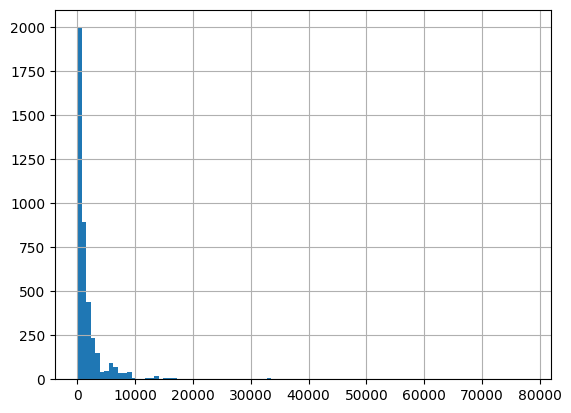

In [ ]:
df2['DPrice'].hist(bins=100)


<Axes: >

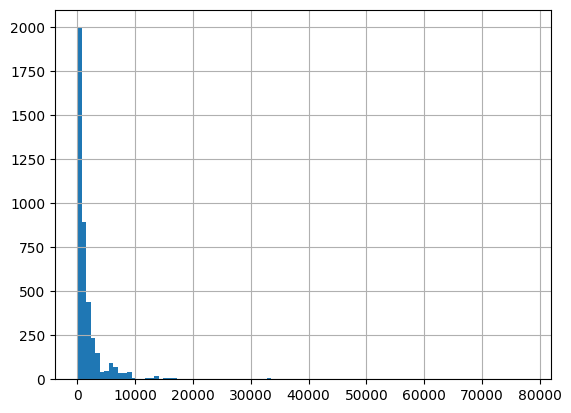

In [ ]:
df2['DPrice'].hist(bins=100)


In [ ]:
df2.dtypes

product_id         object
ProdName           object
category           object
DPrice              int64
APrice             object
DPerct             object
rating            float64
ProdDescr          object
UID                object
UName              object
review_id          object
review_title       object
review_content     object
img_link           object
ProdLink           object
Subcategory        object
dtype: object

In [15]:
col = 'rating'
df2[col]=df2[col].astype(float)
conditions = [
              df2[col].between(0,3),   #CheapPrice  # inclusive = True is the default
              df2[col].between(3,4),  #LowPrice
              df2[col].ge(4) #LittleAboveLowPrice

             ]
choices = ["LR","MR","HR"]

df2['rBucket'] = np.select(conditions, choices, default=np.nan)
df2['rBucket'].unique()

array(['HR', 'MR', 'LR'], dtype=object)

In [ ]:
df2['rBucket'].value_counts()

HR    2651
MR    1502
LR      49
Name: rBucket, dtype: int64

In [16]:
col = 'DPrice'
conditions = [
              df2[col].between(0,500),   #CheapPrice  # inclusive = True is the default
              df2[col].between(500,1000),  #LowPrice
              df2[col].ge(1000) #LittleAboveLowPrice

             ]
choices = ["Low","Medium","High"]

df2['DPBucket'] = np.select(conditions, choices, default=np.nan)
df2['DPBucket'].unique()

array(['Low', 'High', 'Medium'], dtype=object)

In [17]:
def couple(x):
    return ''.join(x['product_id']) + ' '+ ''.join(x['DPBucket'])+ ' '+ ''.join(x['rBucket']) + ' '+ ''.join(x['Subcategory'])

df2['product_classification_features'] = df2.apply(couple, axis=1)

In [20]:
# Let’s calculate the cosine similarity of the product_classification_features for all the products.

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['product_classification_features'])


In [21]:
# Define batch size
batch_size = 500

# Calculate number of batches
num_batches = int(count_matrix.shape[0] / batch_size)

# Initialize an empty array for results
cosine_sim = np.zeros((count_matrix.shape[0], count_matrix.shape[0]))

# Calculate cosine similarity in batches
for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    cosine_sim[start:end] = cosine_similarity(count_matrix[start:end], count_matrix)
    # print(cosine_sim.shape)

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.shape

(4202, 4202)

In [ ]:
def content_recommendation_v1(title):
    a = df2.copy(deep=True).reset_index().drop('index',axis=1)
    index = a[a['product_id']==title].index[0]
    top_n_index = list(cosine_sim_df[index].nlargest(11).index)
    try:
        top_n_index.remove(index)
    except:
        pass
    similar_df = a.iloc[top_n_index][['product_id']]
    similar_df['cosine_similarity'] = cosine_sim_df[index].iloc[top_n_index]
    return similar_df


In [ ]:
cosine_sim_df.shape

(4202, 4202)

In [ ]:
import pandas as pd
from tqdm import tqdm

df3 = pd.DataFrame()
uniqueProds = list(df2['product_id'].unique())

for prodID in tqdm(uniqueProds, desc="Processing Products"):
    try:
        searchedProd = df2[df2['product_id'] == prodID][['Subcategory', 'product_id', 'ProdName']].drop_duplicates().reset_index(drop=True).rename(columns={'product_id': 'searchedProd'})
        suggestedProdIDs = content_recommendation_v1(prodID)
        ProdsID = list(suggestedProdIDs['product_id'])
        suggestedProds = pd.merge(suggestedProdIDs, df2[df2['product_id'].isin(ProdsID)][['product_id', 'Subcategory', 'ProdName']].drop_duplicates(), on='product_id', how='inner')
        suggestedProds = suggestedProds.rename(columns={'cosine_similarity': 'Similarity_Score', 'product_id': 'SuggProd_Id', 'ProdName': 'SuggProdNames'})
        tmpDf = pd.concat([searchedProd, suggestedProds], axis=1).drop_duplicates(subset='SuggProd_Id').reset_index(drop=True)
        df3 = pd.concat([tmpDf, df3], axis=0)
    except Exception as e:
        print(f"Error in prodID {prodID}: {str(e)}")

# Optionally, reset the index of the final DataFrame
df3.reset_index(drop=True, inplace=True)


Processing Products: 100%|██████████| 1102/1102 [00:22<00:00, 48.94it/s]


In [ ]:
df3.shape

(7888, 7)

In [ ]:
###################################################################### Users Clustering #############################################3
#Seperate users for each product
newDf= pd.DataFrame(columns= ['UID',"ProdId","Subcategory","rating"])
for index, row in df2.iterrows():
  # print("usr :", type(row['UID']))
  usrs=row['UID'].split(",")
  tmpDf = pd.DataFrame({'UID': usrs,"ProdId":row['product_id'],"Subcategory": row["Subcategory"],"ProdName":row["ProdName"],'rating':row['rating']})
  newDf= pd.concat([newDf,tmpDf],axis=0,ignore_index = True)
  # print("df2 shape :",df2.shape)

newDf.head()

,UID,ProdId,Subcategory,rating,ProdName
0,AG3D6O4STAQKAY2UVGEUV46KN35Q,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
1,AHMY5CWJMMK5BJRBBSNLYT3ONILA,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
2,AHCTC6ULH4XB6YHDY6PCH2R772LQ,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
3,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
4,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...


In [ ]:
user_item_matrix = pd.pivot_table(newDf,index='UID',columns='ProdId')
user_item_matrix.columns=user_item_matrix.columns.droplevel(0)
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()



<ipython-input-34-0915afd16c88>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  user_item_matrix = pd.pivot_table(newDf,index='UID',columns='ProdId')


ProdId,B002PD61Y4,B002SZEOLG,B003L62T7W,B004IO5BMQ,B005FYNT3G,B0085IATT6,B0085W2MUQ,B0088TKTY2,B008FWZGSG,B008IFXQFU,...,B0BP18W8TM,B0BP7XLX48,B0BP89YBC1,B0BPBG712X,B0BPBXNQQT,B0BPCJM7TB,B0BPJBTB3F,B0BQ3K23Y1,B0BQRJ3C47,B0BR4F878Q
UID,,,,,,,,,,,,,,,,,,,,,
AE22E2AXODSPNK3EBIHNGYS5LOSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE22MK2NXQD3ZARLIOL3SLD4GU6A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23RS3W7GZO7LHYKJU6KSKVM4MQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23WGYTUMB5R6JJMBU4V43JIW7Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

jaccard = scipy.spatial.distance.cdist(user_item_matrix, user_item_matrix,
                                       metric='jaccard')
user_distance = pd.DataFrame(jaccard, columns=user_item_matrix.index.values,
                             index=user_item_matrix.index.values)

In [ ]:
# prepare a dictionary
user_rankings = {}
# iterate over the columns in the dataframe
for user in user_distance.columns:
    # extract the distances of the column ranked by smallest
    distance = user_distance[user].nsmallest(len(user_distance))

    # for each user, create a key in the dictionary and assign a
    # list that contains a ranking of its most similar users
    data = {user : [i for i in distance.index if i!=user]}
    user_rankings.update(data)

In [ ]:
user_rankings['AE22MK2NXQD3ZARLIOL3SLD4GU6A'][0:10] #10 most similar users

['AG2GXBIXLFJD652RYILCZS44PBAA',
 'AHAHSX35S3ZUCKX2UAB3DPGWCYJA',
 'AEZSW3HIRJ2OUNDQHDJEB7NMGUWQ',
 'AFV75LSQUFRY327UWQEBYQKLFSMA',
 'AEPZDUAEBII7N7RRWKTPKON6HB3A',
 'AEUFMJPVYKUAB34FPZ53O2EE7VNQ',
 'AECUHYUPESWI2DB5JMEZQF77VWOA',
 'AGOKXS4TP2M6LTNG5HAEMLCKI2IA',
 'AGOJAM5G7KHARFVDHTRDFHZGR2IA',
 'AGOJ5KXS5VV6NQS3XHAGRDZ7S2BA']

In [ ]:
import pandas as pd
from tqdm import tqdm
import datetime


df4 = pd.DataFrame()
user_rankings_items = list(user_rankings.items())

for index, (UID, simUsr) in tqdm(enumerate(user_rankings_items), desc="Processing User Rankings"):
    try:
        searchedUID = newDf[newDf['UID'] == UID][['UID', 'ProdId', 'Subcategory', 'ProdName', 'rating']].drop_duplicates().reset_index(drop=True)
        sim_usrs_n = simUsr[0:10]  # 10 most similar users
        sim_usrs_df = newDf[newDf['UID'].isin(sim_usrs_n)].rename(columns={'UID': 'SimilarUsers'}).reset_index(drop=True)
        tmpDf = pd.concat([searchedUID, sim_usrs_df], axis=1)
        df4 = pd.concat([tmpDf, df4], axis=0)
    except Exception as e:
        print(f"Error in UID {UID}: {str(e)}")

# Optionally, reset the index of the final DataFrame
df4.reset_index(drop=True, inplace=True)



Processing User Rankings: 7202it [03:08, 38.18it/s]


In [ ]:
df3.head()

,Subcategory,searchedProd,ProdName,SuggProd_Id,Similarity_Score,Subcategory,SuggProdNames
0,SandwichMakers,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,B01486F4G6,1.00,SandwichMakers,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...
1,NaN,NaN,NaN,B07S851WX5,0.75,SandwichMakers,"Prestige Sandwich Maker PGMFD 01, Black"
2,NaN,NaN,NaN,B0B2DD8BQ8,0.75,SandwichMakers,Wipro Vesta Grill 1000 Watt Sandwich Maker |Du...
3,NaN,NaN,NaN,B07GWTWFS2,0.75,SandwichMakers,KENT 16025 Sandwich Grill 700W | Non-Toxic Cer...
4,NaN,NaN,NaN,B09XRBJ94N,0.75,SandwichMakers,iBELL SM1301 3-in-1 Sandwich Maker with Detach...


In [18]:
############################################## Sentiment Analysis #########################33
from transformers import pipeline

# Load BERT model for sentiment analysis
sentiment_classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")



# sentiment_classifier = pipeline(task="text-classification",
#                                 model="nickwong64/bert-base-uncased-poems-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
df2.shape

(4202, 19)

In [ ]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features
783,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps
710,B08TDJNM3G,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,Computers&Accessories|Accessories&Peripherals|...,59,₹59,0%,3.8,"Portable, easy to use|LED lights for maximum i...","AEJGZNKM5ZGH6UY2YX537NWNWYDQ,AGZGGK6OUCCSLXO34...","Ravi Kumar s/o Devraj,anil-kumar,Soumith,Drew ...","R3CEIRJ8YFRONO,R3ICE0RT3T14TH,R17764XIRZDB5H,R...","Good,Product as described,Good for the price,V...","Good,Product is as described, good we can use ...",https://m.media-amazon.com/images/I/413phG1P5U...,https://www.amazon.in/COSMOS-Portable-Flexible...,Lamps,MR,Low,B08TDJNM3G Low MR Lamps
783,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps
1020,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...","RTNU6RMF947TL,R2EDFUKTI01DH4,R2DXZK9Y1QZKSU,R1...",Can be use as table lamp or emergency light fo...,"bright enough to read in close proximity, can ...",https://m.media-amazon.com/images/I/41d-eh65JL...,https://www.amazon.in/SWAPKART-Portable-Readin...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps
783,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps


In [19]:
df2.reset_index(drop=True,inplace=True)

In [ ]:
df2.shape

(4202, 19)

In [ ]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features
4197,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps
4198,B08TDJNM3G,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,Computers&Accessories|Accessories&Peripherals|...,59,₹59,0%,3.8,"Portable, easy to use|LED lights for maximum i...","AEJGZNKM5ZGH6UY2YX537NWNWYDQ,AGZGGK6OUCCSLXO34...","Ravi Kumar s/o Devraj,anil-kumar,Soumith,Drew ...","R3CEIRJ8YFRONO,R3ICE0RT3T14TH,R17764XIRZDB5H,R...","Good,Product as described,Good for the price,V...","Good,Product is as described, good we can use ...",https://m.media-amazon.com/images/I/413phG1P5U...,https://www.amazon.in/COSMOS-Portable-Flexible...,Lamps,MR,Low,B08TDJNM3G Low MR Lamps
4199,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps
4200,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...","RTNU6RMF947TL,R2EDFUKTI01DH4,R2DXZK9Y1QZKSU,R1...",Can be use as table lamp or emergency light fo...,"bright enough to read in close proximity, can ...",https://m.media-amazon.com/images/I/41d-eh65JL...,https://www.amazon.in/SWAPKART-Portable-Readin...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps
4201,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps


In [20]:
# Assuming df is your DataFrame
max_length = 512
df = df[df['review_content'].apply(lambda x: len(x) <= max_length)]

In [ ]:
from tqdm import tqdm
import datetime

df2['label'], df2['score'] = 0, 0

# Use tqdm to track the progress of the loop
for index, row in tqdm(df2.iterrows(), total=len(df2), desc="Processing Sentiment Analysis"):
    try:
        results = sentiment_classifier(row['review_content'])[0]
        df2.at[index, 'label'], df2.at[index, 'score'] = results['label'], round(results['score'] * 100, 2)
    except Exception as e:
        print(f"Error at index {index}: {str(e)}")




In [ ]:
df2.head(2)

In [ ]:
df2.shape

(4202, 21)

In [ ]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features,label,score
4197,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,"Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63
4198,B08TDJNM3G,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,Computers&Accessories|Accessories&Peripherals|...,59,₹59,0%,3.8,"Portable, easy to use|LED lights for maximum i...","AEJGZNKM5ZGH6UY2YX537NWNWYDQ,AGZGGK6OUCCSLXO34...","Ravi Kumar s/o Devraj,anil-kumar,Soumith,Drew ...",...,"Good,Product as described,Good for the price,V...","Good,Product is as described, good we can use ...",https://m.media-amazon.com/images/I/413phG1P5U...,https://www.amazon.in/COSMOS-Portable-Flexible...,Lamps,MR,Low,B08TDJNM3G Low MR Lamps,positive,99.02
4199,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,"Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63
4200,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...",...,Can be use as table lamp or emergency light fo...,"bright enough to read in close proximity, can ...",https://m.media-amazon.com/images/I/41d-eh65JL...,https://www.amazon.in/SWAPKART-Portable-Readin...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps,no_impact,93.30
4201,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,"Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63


In [ ]:
df2.shape

(4202, 25)

In [ ]:
########################

######################## Answer users' question ###############################
from transformers import BertTokenizer, BertForQuestionAnswering,BertForMaskedLM
import torch




# Load the pre-trained BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# model = BertForMaskedLM.from_pretrained("bert-base-uncased")
# model.eval()  # Set the model to evaluation mode



In [21]:
df2.tail(2)

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features
4200,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...","RTNU6RMF947TL,R2EDFUKTI01DH4,R2DXZK9Y1QZKSU,R1...",Can be use as table lamp or emergency light fo...,"bright enough to read in close proximity, can ...",https://m.media-amazon.com/images/I/41d-eh65JL...,https://www.amazon.in/SWAPKART-Portable-Readin...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps
4201,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...","R1YVU5NMCJDX8M,R3MG5C14NRKOHR,R1T3DO26SFI3TL,R...","Good & attractive,Very versatile,Good,Good Pro...",Some USB ports are little loose but I will man...,https://m.media-amazon.com/images/I/318Gp3pIqX...,https://www.amazon.in/DASITON-Flexible-Ambient...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps


In [ ]:
df2.shape

(4202, 25)

In [22]:
############################### Summarize Product Description to users ##############################333
summarizer = pipeline(task="summarization",
                      model = "t5-small",
                       min_length=20,
                       max_length=40,
                       truncation=True)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [25]:
df2.at[192,"ProdDescr"]

'Usb-A To Lightning Cable'

(array([ 658., 1089.,  866.,  589.,  372.,  210.,  124.,   97.,   48.,
           6.]),
 array([ 11. ,  50.5,  90. , 129.5, 169. , 208.5, 248. , 287.5, 327. ,
        366.5, 406. ]),
 <BarContainer object of 10 artists>)

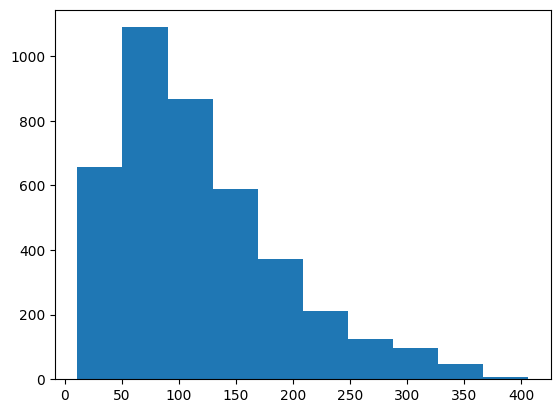

In [33]:
lens=[len(i.split()) for i in df2.ProdDescr]

import matplotlib.pyplot as plt
plt.hist(lens)


In [34]:
# Let's filter out product descriptions which are lesser than 50 in size.
min_prodesc_len = 150
df2 = df2[df2['ProdDescr'].apply(lambda x: len(x) >= min_prodesc_len)]

In [ ]:
from tqdm import tqdm


df2['T5-Summ'] = 0

# Wrap your loop with tqdm to display a progress bar
for index, row in tqdm(df2.iterrows(), total=len(df2), desc="Processing"):
    try:
        results = summarizer(row['ProdDescr'])[0]['summary_text']
        df2.at[index, 'T5-Summ'] = results
    except Exception as e:
        print(f"Exception at index {index}: {e}")



Processing:  82%|████████▏ | 3261/3964 [41:13<08:32,  1.37it/s]

In [ ]:
# # Function to summarize text using the GPT-3 model
# def summarize_text(input_text, max_tokens=50):
#     response = openai.Completion.create(
#         engine="davinci",  # You can use another engine if needed
#         prompt=f"Summarize the following text:\n{input_text}\nSummary:",
#         max_tokens=max_tokens,  # Adjust max_tokens as per your needs
#         n=1,  # Number of completions to generate
#     )
#     summary = response.choices[0].text.strip()
#     return summary


In [ ]:
# start_time = datetime.datetime.now()


# df2['ProdSummary2']= 0

# for index, row in df2[0:5].iterrows():
#   try:
#     print("index :",index)
#     summary= summarize_text(input_text)
#     df2.at[index,'ProdSummary2'] = summary
#   except:
#     print("except index :",index)
#     pass

# end_time = datetime.datetime.now()

# # Calculate the time difference in seconds
# time_difference = (end_time - start_time).total_seconds()

# print("The time difference is:", round((time_difference/60),2), "mnts")

index : 0
index : 1
index : 2
index : 3
except index : 3
index : 4
except index : 4
index : 5
except index : 5
index : 6
except index : 6
index : 7
except index : 7
index : 8
except index : 8
index : 9
except index : 9
index : 10
except index : 10
index : 11
except index : 11
index : 12
except index : 12
index : 13
except index : 13
index : 14
except index : 14
index : 15
except index : 15
index : 16
except index : 16
index : 17
except index : 17
index : 18
except index : 18
index : 19
except index : 19
index : 20
except index : 20
index : 21
except index : 21
index : 22
except index : 22
index : 23
except index : 23
index : 24
except index : 24
index : 25
except index : 25
index : 26
except index : 26
index : 27
except index : 27
index : 28
except index : 28
index : 29
except index : 29
index : 30
except index : 30
index : 31
except index : 31
index : 32
except index : 32
index : 33
except index : 33
index : 34
except index : 34
index : 35
except index : 35
index : 36
except index : 3

In [ ]:
# Export DataFrames to Excel using ExcelWriter
with pd.ExcelWriter('data.xlsx') as excel_writer:
    df.to_excel(excel_writer, sheet_name='OrgData', index=False)
    df3.to_excel(excel_writer, sheet_name='ProdsClustering', index=False)
    df4.to_excel(excel_writer, sheet_name='UsrsClustering', index=False)
    df2.to_excel(excel_writer, sheet_name='ConvAI', index=False)
